<a href="https://colab.research.google.com/github/Matinsalami/DataScience/blob/main/Hands_on_Machine_Learning/Chapter_7/Ensemble_Learning_and_Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A group of predictors are called **Ensemble** and using this ensemble to get a better prediction on a dataset is called **Ensemble Learning**. An Ensemble Learning algorithm is called an Ensemble method. Here se discuss different methods for regressors and classifiers.  

#Voting Classifiers

Having trained a number of different classifiers on a dataset(SVM, Random Forest, K-Nearest Neighbors e.g.), a very simple way to have a better classifier is to aggregate the predictions pf each classifier and predict the class that gets the most votes. This new classifier seems to achieve better accuracy even if each classifier in the ensemble is weak learner, the ensemble can still be a strong learner provided there are a sufficient number of weak learners and they are sufficiently diverse.

Note: Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble's accuracy.

This is an example of hard-voting classifier:

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load dataset
X, y = load_iris(return_X_y=True)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define base classifiers
clf1 = LogisticRegression(max_iter=1000)
clf2 = DecisionTreeClassifier()
clf3 = SVC(probability=False)  # no need for probabilities in hard voting
clf4 = RandomForestClassifier()

# Create hard voting ensemble
voting_clf = VotingClassifier(
    estimators=[('lr', clf1), ('dt', clf2), ('svc', clf3), ('rf', clf4)],
    voting='hard'  # 'hard' = majority voting
)

# Train the ensemble
voting_clf.fit(X_train, y_train)

for clf in (clf1,clf2,clf3,clf4,voting_clf):
  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  print("Accuracy: ", accuracy_score(y_test,y_pred))

Accuracy:  1.0
Accuracy:  1.0
Accuracy:  1.0
Accuracy:  1.0
Accuracy:  1.0


If all the classifiers in the ensemble have a dict_proba() method, meaning they are able to estimate class probabilities, we can use soft voting classifier. It often achieves higher performance than hard voting classifier because it gives more weight to highly confident votes. In Scikit-Learn you only need to replace `voting="hard"` with `voting="soft"`.

Note: In SVM you need to set its `probability` hyperparameter to `True`.  

# Bagging and Pasting

  

Another approach to get a diverse set of classifiers is to use the same algorithm for every predictor, but to train them on different subsets of the training set. Both of these methods are totally scalable

**Bagging**:sampling performed with replacement.

**Pasting**:sampling performed without replacement.

Once all the predictors are trained =, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors. For classification we usually use hard voting, for regression we use average of the values.

Note: Generally the result is that the ensemble has a similar bias but lower varience than a single predictor trained on the original training set.

## Bagging and Pasting in Scikit-Learn

If you want to use bagging ----> `bootstrap=True`

If you want to use pasting ----> `bootstrap=False`

`n_jobs = -1` indicated that all the cores of the cpu is used for training and prediction. Else, it will use the number of cores indicated in the model.

For regression we can use `BaggingRegressor` class

Note:The bagging classfifier automatically performs soft voting if the base classifier can estimate class probabilities. (i.e., it has `predict_proba()` method)

boostrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting.
Overall bagging often results in better models, which explains why it is generally preferred.

Accuracy: 0.9


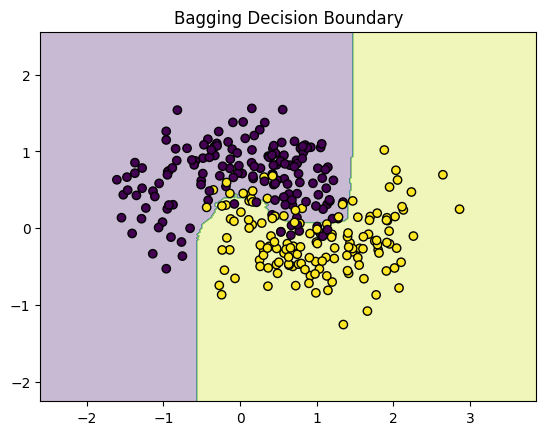

In [3]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Generate the moons dataset
X, y = make_moons(n_samples=1000, noise=0.3, random_state=42)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create BaggingClassifier with DecisionTreeClassifier as base estimator
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,  # Set to False to do pasting
    n_jobs=-1,
    random_state=42,
    oob_score=True
)

# Train the bagging classifier
bag_clf.fit(X_train, y_train)

# Make predictions
y_pred = bag_clf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))

# (Optional) Plot decision boundary
import numpy as np

def plot_decision_boundary(clf, X, y, ax=None):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    if ax is None:
        ax = plt.gca()
    ax.contourf(xx, yy, Z, alpha=0.3)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')
    plt.title("Bagging Decision Boundary")

plot_decision_boundary(bag_clf, X_test, y_test)
plt.show()

## Out-of-Bag Evaluation

With bagging, some instances may be sampled several times while others may not be sampled at all. By default a `BaggingClassifier` samples m training instances with replacement(`bootstrap=True`). On average 37% of the instances are never sampled by the estimator. We can use these *Out_of_bag* instances as a validation score for the predictor.

To use this score, you can set `oob_score=True` in the bagging classfier.
(In other words, we have another test set in training set that can be used).

By looking at accuracy score of the classifier e can see that the accuracy score is pretty close to oob_score.

To take the value of oob_score e can use `oob_score` attribute of the model.

Also if the base model has a `dict_proba()` method, we can use `oob_decision_function_`to print oob decision probability for each training instance

In [4]:
bag_clf.oob_score_

0.9114285714285715

In [5]:
bag_clf.oob_decision_function_

array([[0.98578199, 0.01421801],
       [0.97163121, 0.02836879],
       [0.28735632, 0.71264368],
       ...,
       [0.96736597, 0.03263403],
       [0.71624714, 0.28375286],
       [0.05128205, 0.94871795]])

# Random Patches and Random Subspaces

The bagging classifier class supports sampling the features as well. We use two hyperparameters for this called `max_features` and `bootstrap_features`. So each predictor will be trained on a random subset of features.

This is useful when we deal with high-dimensional inputs(images e.g.). Sampling both training instances and features is called the **Random Patches method**.

Keeping all training instances(i.e., `bootstrap=False` and `max_samples=1.0`) but sampling features(i.e., `bootstrap_features=True`, `max_features` < 1.0) is called **Random Subspaces method**.

With **Random Patches method** we have a lower variance which is traded with a little higher bias.

#Random Forests

Random Forest is an ensemble of Decision Trees, generally trained via the bagging method.

RandomForestClassifier has almost all the hyperparameters that DecisionTreeClassifier has to control how the trees are grown and also almost all the hyperparameters of baggingClassifier to control the ensemble itself.

In [6]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)

rnd_clf.fit(X_train,y_train)

y_pred = rnd_clf.predict(X_test)

Random Forest algorithm introduces extra randomness when growing trees. It choos a random set of features among the features. And choose the best one among them. This results in a greater tree diversity, which agian trades a higher bias for a lower variance. Generally yeilding an overall better model.

In [7]:
#This classifier is roughly equivalent to the previous RandomForest.
bag_clf = BaggingClassifier(DecisionTreeClassifier(splitter="random", max_leaf_nodes=16), n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

## Extra-Trees

When training a Random Forest, at each node only a random set of feature is considered for splitting. It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds. Such a forest is called **Extremely Randomized Trees** ensemble. Once again this trades less variance for more bias. Also this method is much faster than regular RandomForest.

Use `ExtraTreesClassifier` from Sklearn API which is identical to `RandomForestClassifier`.

## Feature importance

Random Forest can estimate how important each feature is in predicting the target which is called **Feature Importance**. To get the importance of each feature use `feature_importance_` variable of Random Forest classifier. This can be used in feature selection.

The below plot shows the importance of each pixel(features) of the dataset in the MNIST dataset.

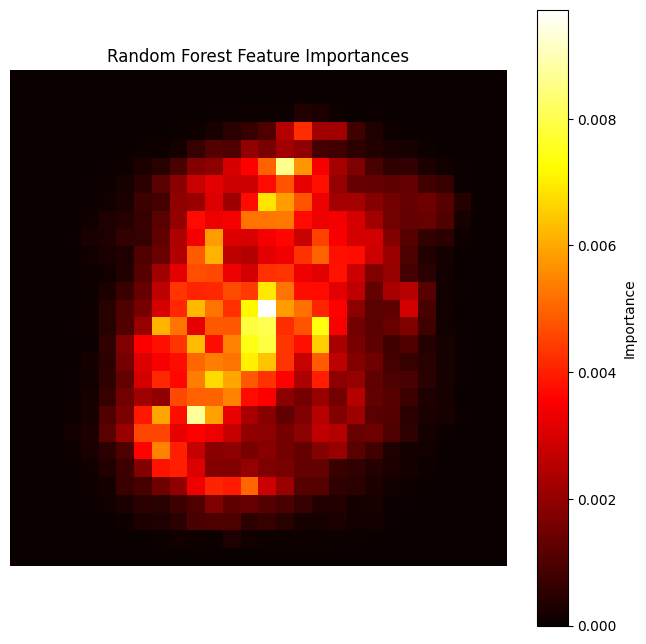

In [8]:
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Load full MNIST dataset (70000 samples, 784 features)
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

# For speed: optionally downsample (e.g., to 10000 samples)
X, y = X[:10000], y[:10000]

# Convert labels to integers
y = y.astype(np.uint8)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

# Get feature importances
importances = rf_clf.feature_importances_

# Reshape to 28x28 image
importances_image = importances.reshape(28, 28)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(importances_image, cmap='hot', interpolation='nearest')
plt.title("Random Forest Feature Importances")
plt.colorbar(label="Importance")
plt.axis('off')
plt.show()


# Boosting

Boosting refers to any Ensemble method that can combine several weak learner into a strong learner. The general idea is to train the models sequentailly while each predictor tries to correct its predecessor.

## AdaBoost

The core idea is to pay attention to the underfitted data. The new predictors focuses more and more on the hard cases.

To build an AdaBoost classifier, a first base classifier (such as a Decision Tree) is trained and used to make predictions on the training set. The relative weight of the misclassified training instances is then increased. A second classifier is then trained using the weighted data and it again make predictions. Weights are then updated and so on. Once all the predictors are trained, the ensemble makes predictions very much like bagging and pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.

Note: There is a drawback with AdaBoost that is it cannot be parallelized, since each predictor is trained after previous training is finished. As a result it does not scale so well like bagging or pasting.

Note: If AdaBoost ensemble is overfitting the data, reducing the number of estimators or more strongly regularizing the base estimaator may works.

The following code snippet shows how AdaBoost works:


In [14]:
pip install --upgrade scikit-learn

In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree     import DecisionTreeClassifier


ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1,), # A week learner which is a Decision tree stamp with one split
    n_estimators=200, # number of boosting performed by the AdaBoost classifier
    algorithm="SAMME",
    learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

# Gradient Boosting

This method tries to fit the new predictors to the residual errors made by the previous predictor. the predictions of all previous models are added up to make a better prediction on the data.

GBRT or (Gradient Boosted Regression Tree) is a type of Gradient boosted algorithm for regression tasks.

There is a regularization technique called shrinkage: set a lo value for learning rate and increase the n_estimators.


To use GBRT we can use sklearn.




In this code we use `staged_predict()` by the predictor: it returns an iterator over the predictions made by the ensemble at each stage of training. This code shows a gbrt which start learning up to 120 estimators computing the errors made in each step and finally finding the index of (the lowest error + 1) which is the n_estimators with which the gbrt produces the smallest error.

In [19]:
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Load a built-in regression dataset
data = load_diabetes()
X, y = data.data, data.target

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initial training with many trees
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

# Compute validation errors after each stage
errors = [
    mean_squared_error(y_val, y_pred)
    for y_pred in gbrt.staged_predict(X_val)
]
best_n_estimators = np.argmin(errors) + 1  # index→count of trees

# Retrain with optimal number of trees
gbrt_best = GradientBoostingRegressor(
    max_depth=2, n_estimators=best_n_estimators, random_state=42
)
gbrt_best.fit(X_train, y_train)

# Evaluate performance
test_prediction = gbrt_best.predict(X_val)
test_mse = mean_squared_error(y_val, test_prediction)

print(f"Best number of trees: {best_n_estimators}")
print(f"Validation MSE at best trees: {errors[best_n_estimators-1]:.4f}")
print(f"Test MSE with optimal model: {test_mse:.4f}")


Best number of trees: 41
Validation MSE at best trees: 2695.6301
Test MSE with optimal model: 2695.6301


Also we can have early stopping to stop the learning early.
This code shows such a thing.

In [23]:
gbrt = GradientBoostingRegressor(max_depth=2,warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1,120):
  gbrt.n_estimators = n_estimators # update the number of estimators each time
  gbrt.fit(X_train,y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5: # if the error grows for 5 consecutive training
      break


We have another technique in GBRT which is by using hyperparameter `subsample`. if we change it in an interval of (0,1) then we can tell the predictor what percent of the training data to use for each tree. This is again trading off higher bias for lower variance. This technique is called **Stochastic Gradient Boosting**.

Also there is a loss parameter in Gradient Boosting which is the cost function used and it can be changed.  

## XGBoost

XGBoost is an optimized version of gradient boosting. It stands for Extreme Gradient Boosting. It is relatively fast, scalable and portable.

In [41]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    early_stopping_rounds=2
)
xgb.fit(
    X_train, y_train,eval_set=[(X, y)]
)


[0]	validation_0-rmse:74.92557
[1]	validation_0-rmse:72.96732
[2]	validation_0-rmse:71.15928
[3]	validation_0-rmse:69.48538
[4]	validation_0-rmse:67.87142
[5]	validation_0-rmse:66.40852
[6]	validation_0-rmse:65.01773
[7]	validation_0-rmse:63.62780
[8]	validation_0-rmse:62.36402
[9]	validation_0-rmse:61.15535
[10]	validation_0-rmse:60.01866
[11]	validation_0-rmse:58.94825
[12]	validation_0-rmse:57.96721
[13]	validation_0-rmse:57.03892
[14]	validation_0-rmse:56.15897
[15]	validation_0-rmse:55.36927
[16]	validation_0-rmse:54.58801
[17]	validation_0-rmse:53.87605
[18]	validation_0-rmse:53.09832
[19]	validation_0-rmse:52.47566
[20]	validation_0-rmse:51.80527
[21]	validation_0-rmse:51.27370
[22]	validation_0-rmse:50.65509
[23]	validation_0-rmse:50.11063
[24]	validation_0-rmse:49.56774
[25]	validation_0-rmse:49.13128
[26]	validation_0-rmse:48.66439
[27]	validation_0-rmse:48.22418
[28]	validation_0-rmse:47.79393
[29]	validation_0-rmse:47.39907
[30]	validation_0-rmse:47.02134
[31]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=2,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)